In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from ztfquery import sedm, io
import pysedm
import numpy as np
import os
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi = False

In [26]:
from hypergal import io as ioh
from hypergal.spectroscopy import WCSCube
from hypergal import spectroscopy, photometry

# Get data. Target _ZTF20aamifit_

## Download data cubes from *minar*, as well as HexaGrid and astrometry
Skip downloading part if files already exist. \
Get redshift and sky position (radec) from Fritz.

In [3]:
cubefiles,radec,redshift = ioh.get_target_info('ZTF20aamifit');

/Users/lezmy/opt/anaconda3/lib/python3.8/site-packages/ztfquery-1.18.2-py3.8.egg/ztfquery/sedm.py:546: UserWarning: 'whatfiles' already up to date
  warnings.warn("'whatfiles' already up to date")
/Users/lezmy/opt/anaconda3/lib/python3.8/site-packages/ztfquery-1.18.2-py3.8.egg/ztfquery/io.py:692: UserWarning: /Users/lezmy/Data/ztf/sedm/redux/20220204/e3d_crr_b_ifu20220204_12_09_51_ZTF20aamifit.fits already exists: skipped
  warnings.warn("%s already exists: skipped"%fileout)
/Users/lezmy/opt/anaconda3/lib/python3.8/site-packages/ztfquery-1.18.2-py3.8.egg/ztfquery/io.py:692: UserWarning: /Users/lezmy/Data/ztf/sedm/redux/20220203/e3d_crr_b_ifu20220203_12_59_06_ZTF20aamifit.fits already exists: skipped
  warnings.warn("%s already exists: skipped"%fileout)
/Users/lezmy/opt/anaconda3/lib/python3.8/site-packages/ztfquery-1.18.2-py3.8.egg/ztfquery/io.py:692: UserWarning: /Users/lezmy/Data/ztf/sedm/redux/20200217/e3d_crr_b_ifu20200217_11_39_59_ZTF20aamifit.fits already exists: skipped
  warnin

In [7]:
cubefiles, radec, redshift

(array(['/Users/lezmy/Data/ztf/sedm/redux/20200217/e3d_crr_b_ifu20200217_11_39_59_ZTF20aamifit.fits',
        '/Users/lezmy/Data/ztf/sedm/redux/20220203/e3d_crr_b_ifu20220203_12_59_06_ZTF20aamifit.fits',
        '/Users/lezmy/Data/ztf/sedm/redux/20220204/e3d_crr_b_ifu20220204_12_09_51_ZTF20aamifit.fits'],
       dtype='<U90'),
 (275.7067393, 47.8320214),
 0.045)

## Let's use the observation of 17/02/2022

/Users/lezmy/opt/anaconda3/lib/python3.8/site-packages/pyifu-0.11.1-py3.8.egg/pyifu/tools.py:357: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


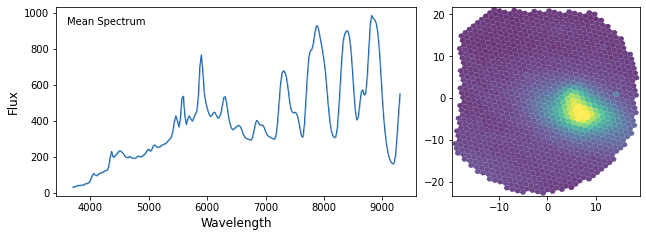

In [5]:
cubefile = cubefiles[0]
cube = pysedm.get_sedmcube( cubefile)
cube.show()

## Get photometry data from PS1

In [6]:
size=140 #size in pixel (0.25"/pixel)
cutouts = photometry.panstarrs.PS1CutOuts.from_radec(*radec, size=size)

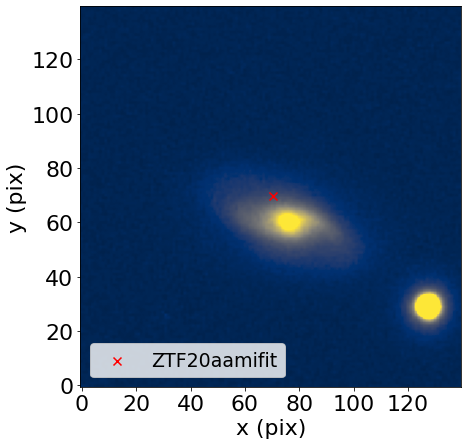

In [12]:
fig,ax=plt.subplots( figsize=(7,7))

cutouts.show(vmax='99.5',ax=ax, filter_='ps1.r') # show r-band

ax.scatter( *cutouts.radec_to_xy(*radec), s=64,  # detected position by ZTF of the supernova
           zorder=11,c='r', marker='x', 
           label='ZTF20aamifit')

ax.legend(loc='lower left', fontsize=19)
ax.set_aspect('equal')
ax.set_xlabel(r"x (pix)", fontsize=22)
ax.set_ylabel(r"y (pix)", fontsize=22)
ax.set_xticks(ax.get_yticks())
ax.set_xlim(-0.5,139.5)
ax.set_ylim(-0.5,139.5)
ax.tick_params(labelsize=22)

### Tip for RGB image from PS1

In [13]:
from __future__ import print_function
from astropy.table import Table
import requests
from PIL import Image
from io import BytesIO
import pylab

def getimages(ra,dec,size=140,filters="grizy"):
    
    """Query ps1filenames.py service to get a list of images
    
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    Returns a table with the results
    """
    
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = ("{service}?ra={ra}&dec={dec}&size={size}&format=fits"
           "&filters={filters}").format(**locals())
    table = Table.read(url, format='ascii')
    return table


def geturl(ra, dec, size=240, output_size=None, filters="grizy", format="jpg", color=False):
    
    """Get URL for images in the table
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    Returns a string with the URL
    """
    
    if color and format == "fits":
        raise ValueError("color images are available only for jpg or png formats")
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    table = getimages(ra,dec,size=size,filters=filters)
    url = ("https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           "ra={ra}&dec={dec}&size={size}&format={format}").format(**locals())
    if output_size:
        url = url + "&output_size={}".format(output_size)
    # sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[np.argsort(flist)]
    if color:
        if len(table) > 3:
            # pick 3 filters
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
    return url


def getcolorim(ra, dec, size=240, output_size=None, filters="grizy", format="jpg"):
    
    """Get color image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    url = geturl(ra,dec,size=size,filters=filters,output_size=output_size,format=format,color=True)
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im


def getgrayim(ra, dec, size=240, output_size=None, filter="g", format="jpg"):
    
    """Get grayscale image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filter = string with filter to extract (one of grizy)
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    if filter not in list("grizy"):
        raise ValueError("filter must be one of grizy")
    url = geturl(ra,dec,size=size,filters=filter,output_size=output_size,format=format)
    r = requests.get(url[0])
    im = Image.open(BytesIO(r.content))
    return im

In [14]:
cim = getcolorim( *radec,size=size,filters="grz")

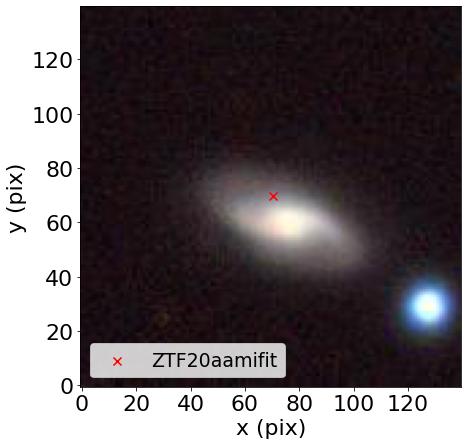

In [15]:
fig,ax=plt.subplots( figsize=(7,7))
ax.imshow(cim,origin='upper', extent=[-0.5,139.5,-0.5,139.5])
ax.scatter( *cutouts.radec_to_xy(*radec), s=64, zorder=11,c='r', marker='x', label='ZTF20aamifit')
ax.legend(loc='lower left', fontsize=19)
ax.set_aspect('equal')
ax.set_xlabel(r"x (pix)", fontsize=22)
ax.set_ylabel(r"y (pix)", fontsize=22)
ax.set_xticks(ax.get_yticks())
ax.set_xlim(-0.5,139.5)
ax.set_ylim(-0.5,139.5)
ax.tick_params(labelsize=22)

## Build cube from the 5 _grizy_ bands

In [16]:
cout_cube = cutouts.to_cube(binfactor=2, influx=True) # binfactor spatially resample the data

/Users/lezmy/opt/anaconda3/lib/python3.8/site-packages/pyifu-0.11.1-py3.8.egg/pyifu/tools.py:357: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


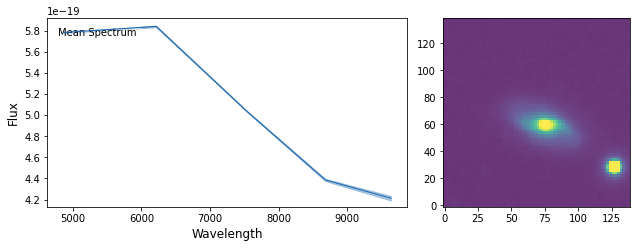

In [17]:
cout_cube.show()

# SED fitting step (*Cigal*)

In [20]:
working_dir = 'tmp_ifu20200217_11_39_59' # Computation will be done in the working_dir

from pysedm.sedm import SEDM_LBDA        
lbda = SEDM_LBDA                   # Get SEDM spectral space

tmp_inputpath = os.path.join(working_dir, "input_sedfitting.txt")  # input file name for Cigal

ncores=10 # for multiprocessing
saveplot_rmspull = 'cigale_pullrms.png'# valdiation plot name
saveplot_intcube = 'intcube.png'

In [27]:
sfitter = spectroscopy.sedfitting.Cigale.from_cube_cutouts(cout_cube, redshift,
                                                           tmp_inputpath=tmp_inputpath,
                                                           initiate=True, snr=3, # threshold in S/N for all bands to consider a pixel
                                                           working_dir=working_dir,
                                                           ncores=ncores)

The initial configuration file was created. Please complete it with the data file name and the pcigale modules to use.
No AGN module found. Options are: fritz2006, skirtor2016.
No radio module found. Options are: radio.
No restframe parameters module found Options are: restframe_parameters.
The configuration file has been updated. Please complete the various module parameters and the data file columns to use in the analysis.


In [28]:
bestmodel_dir = sfitter.run() # run SED fitting

Initialising the analysis module... 

Processing block 1/1...

Computing models ...

Estimating the physical properties ...

Block processed.

Estimating physical properties on all blocks

Computing the best fit spectra

Sanity check of the analysis results...
0.0% of the objects have χ²_red~0 and 93.2% χ²_red<0.5

Saving the analysis results...
Run completed!


# Extraction of the hyperspectral model

In [29]:
import dask
from dask.distributed import Client

client = Client() #not mandatory, speed up the projection in the SEDm spectral space (convolution)
client

Client Scheduler: tcp://127.0.0.1:58935 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 16.00 GiB


## Get all spectra in SEDm space

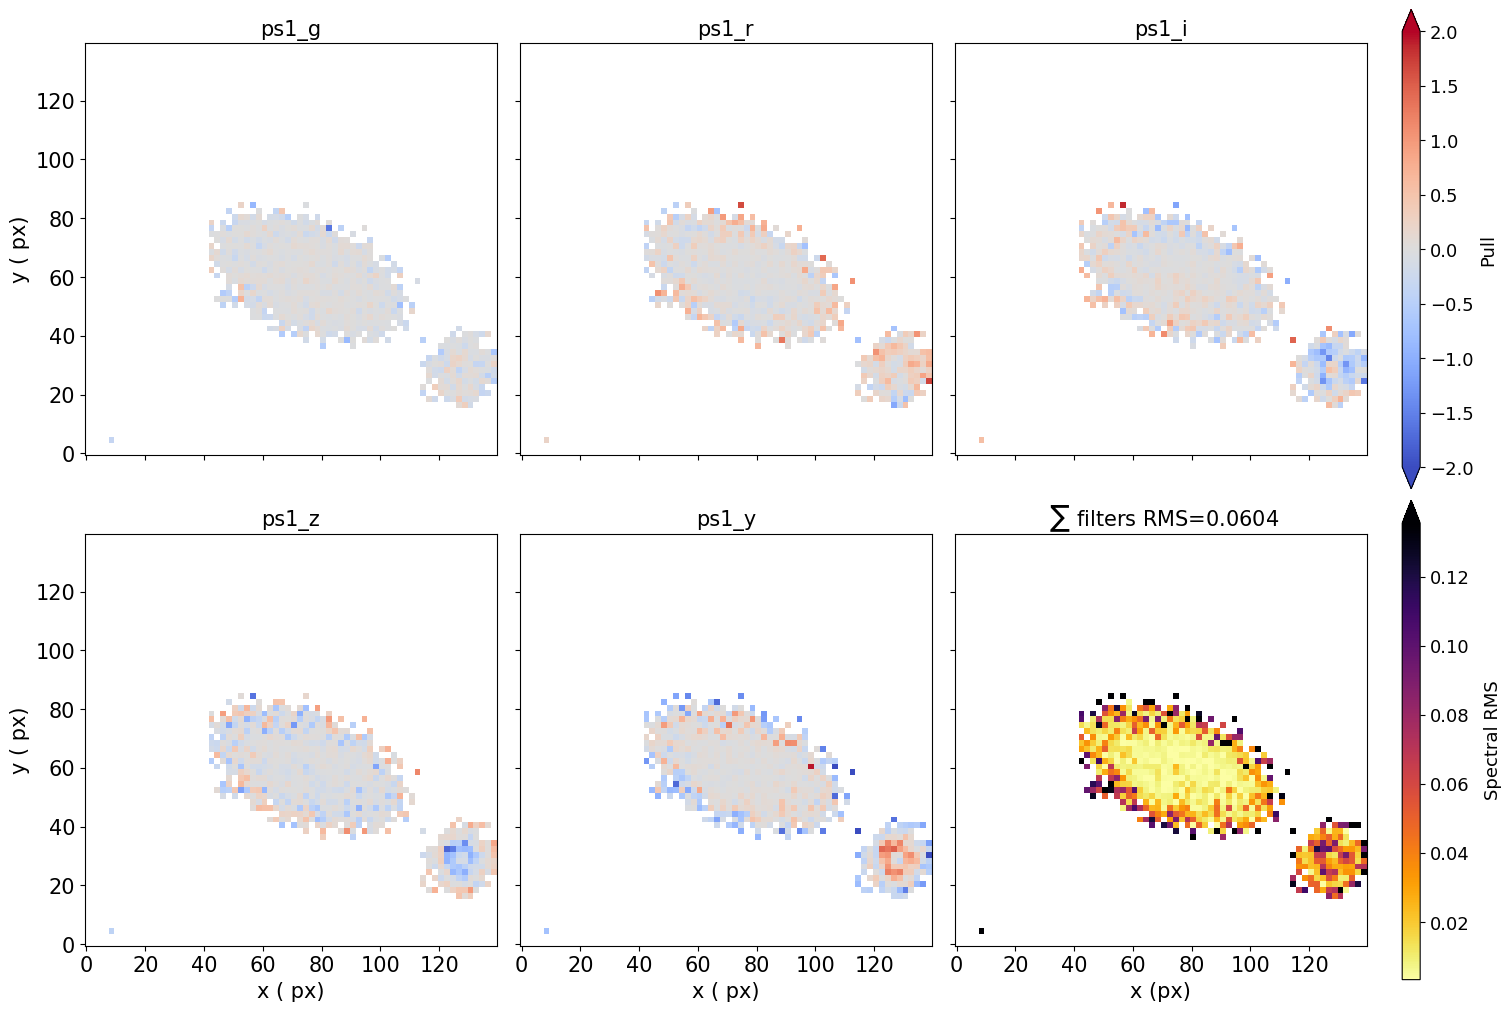

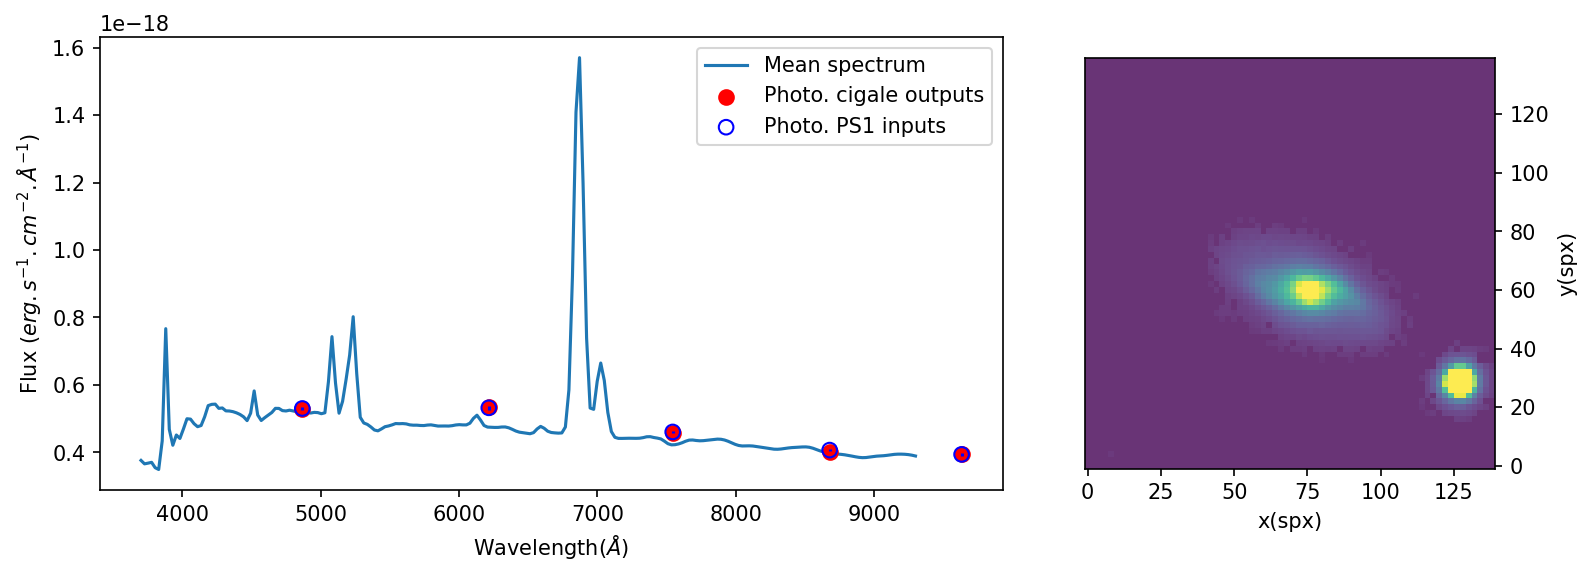

In [30]:
spectra_lbda = sfitter.get_sample_spectra(bestmodel_dir=bestmodel_dir,
                                          lbda_sample=lbda,
                                          saveplot_rmspull=saveplot_rmspull,
                                          saveplot_intcube=saveplot_intcube, 
                                          apply_sedm_lsf=True, client=client, # apply_sedm_lsf: convolve each spectrum with SEDm LSF
                                          backcurrent_dir=True)  # once computation done, leave the working_dir and go back in the original directory
 
specdata = spectra_lbda[0]
lbda = spectra_lbda[1]

## Build hyperspectral model

In [31]:
intcube = cout_cube.get_new(newdata=specdata, newlbda=lbda, newvariance="None")

/Users/lezmy/opt/anaconda3/lib/python3.8/site-packages/pyifu-0.11.1-py3.8.egg/pyifu/tools.py:357: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


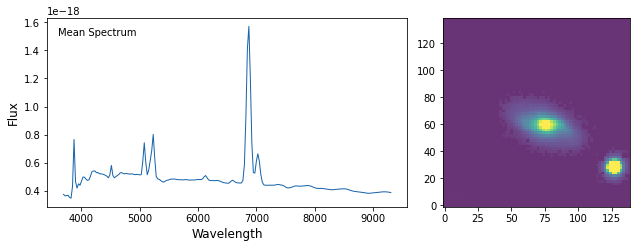

In [32]:
intcube.show()